In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

from astropy import units as u
from astropy import constants as c
from astropy.io import fits
from astropy.table import Table

%matplotlib inline

sns.set(style="white", context="talk", palette="colorblind", color_codes=True)

# Inspecting the data

###### filename breakdown example: LBL_A30_s0_w035_R_300000

###### Line-by-Line_Airmass 3.0_s0_3.5mm of PWV (precitable water vapor)_R_resolution

###### lam ranges from 0.3 to 30 um (300 - 30000 nm) (~ UVC - microwave)

###### lam in base units of um

In [2]:
with fits.open("./data/LBL_A10_s0_w200_R0300000_T.fits") as hdu:
    data = hdu[1].data

## Entire sample spectra

In [23]:
# `to_pandas` avoids "endianness" bug `DataFrame(data)` would hit
# https://github.com/astropy/astropy/issues/1156
df_all = Table(data).to_pandas()
display(df_all)
display(df_all.describe())

,lam,trans,mnstrans,plstrans
0,0.300000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.300001,0.000000e+00,0.000000e+00,0.000000e+00
2,0.300002,0.000000e+00,0.000000e+00,0.000000e+00
3,0.300003,0.000000e+00,0.000000e+00,0.000000e+00
4,0.300004,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...
1381549,29.999564,4.022928e-42,4.022928e-42,4.022928e-42
1381550,29.999664,4.290776e-42,4.290776e-42,4.290776e-42
1381551,29.999764,4.570335e-42,4.570335e-42,4.570335e-42
1381552,29.999864,4.867680e-42,4.867680e-42,4.867680e-42


,lam,trans,mnstrans,plstrans
count,1.381554e+06,1.381554e+06,1.381554e+06,1.381554e+06
mean,6.449273e+00,5.196543e-01,5.196543e-01,5.196543e-01
std,7.490891e+00,4.395209e-01,4.395209e-01,4.395209e-01
min,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.486830e-01,4.651063e-06,4.651063e-06,4.651063e-06
50%,2.999998e+00,6.826737e-01,6.826737e-01,6.826737e-01
75%,9.486824e+00,9.755292e-01,9.755292e-01,9.755292e-01
max,2.999996e+01,1.000002e+00,1.000002e+00,1.000002e+00


## Section of spectra

#### Using a section of the spectra for now will speed up tests

In [40]:
df = df_all.query("0.41 <= lam <= 0.425")
df

,lam,trans,mnstrans,plstrans
93713,0.410001,0.999942,0.999942,0.999942
93714,0.410002,0.999942,0.999942,0.999942
93715,0.410003,0.999942,0.999942,0.999942
93716,0.410005,0.999942,0.999942,0.999942
93717,0.410006,0.999942,0.999942,0.999942
...,...,...,...,...
104488,0.424994,0.999689,0.999689,0.999689
104489,0.424995,0.999689,0.999689,0.999689
104490,0.424997,0.999689,0.999689,0.999689
104491,0.424998,0.999689,0.999689,0.999689


Text(0.5, 1.0, 'Airmass 1.0')

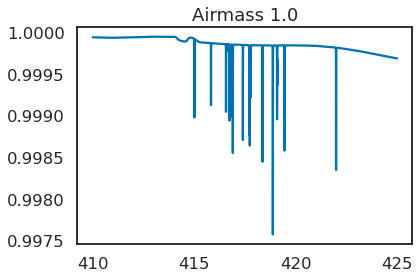

In [41]:
# just using 410 - 420 nanometers for now
plt.plot(df.lam*1E3, df.trans)

plt.title('Airmass 1.0')

# Generalizing to multiple spectra now

## To make a time series, the same library with different airmasses will be used to simulate the amount of water vapor changing with time. 
## The mm of water vapor will remain set at 20 mm for now for each airmass.

In [ ]:
pathnames = glob.glob('./data/*')

In [ ]:
# Will hold airmass 1.0 ... 3.0
lam_list   = []
trans_list = []

# holds binned values
lam_bin_list   = [] # [am=1.0, am=1.5, ..., am=3.0]
trans_bin_list = []

for i in pathnames:
    hdu_list = fits.open(i)
    hdu_data = hdu_list[1].data
    hdu_list.close()
    
    lam   = hdu_data['lam']
    trans = hdu_data['trans']
    
    lam_list.append(lam)
    trans_list.append(trans)
    
    # just cut out a piece to analyze for now
    lam_bin = lam[(0.41 <= lam) & (lam <= 0.425)]
    trans_bin = trans[(0.41 <= lam) & (lam <= 0.425)] 
    
    lam_bin_list.append(lam_bin)
    trans_bin_list.append(trans_bin)

## Here is what the five different airmasses being used look like relative to each other for this set window

In [ ]:
am_list = [1.0, 1.5, 2.0, 2.5, 3.0]
for i,j in enumerate(reversed(am_list)): # to make overlapping easier to see
    i=i+1
    plt.plot(lam_bin_list[-i]*1E3, trans_bin_list[-i], label='airmass %.1f' % j)
    
plt.legend(loc='best')
#plt.ylim(0.998, 1)
#plt.xlim(410, 415)

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('normalized transmission')

#plt.savefig('./figures/spectra_stack.pdf')

## Next, binnes within this window for one of the airmasses will be setup
## to investigate the stdev and average flux as a function of binsize.
## The left side of the bin will be anchored at 410nm and extended to the right side 

In [ ]:
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm
# holds corresponding binright -> wavelength
wav_list = np.arange(410 + bin_intv.value, 425 + bin_intv.value, bin_intv.value) * u.nm
trans_n = trans_list[0] # will be randomized later

flux_avg_list = []
stdev_list = []
binright = 0
for i in range(bin_num):
    binright += bin_intv
    trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.41 + binright.to('micrometer').value)]
    
    # store stats
    flux_avg_list.append(np.mean(trans_bin))
    stdev_list.append(np.std(trans_bin))

## Average flux vs binsize

In [ ]:
plt.plot(wav_list, flux_avg_list)

plt.xlabel('bin right side (nm)')
plt.ylabel('normalized average flux')

## Flux standard deviation vs binsize

In [ ]:
plt.plot(wav_list, stdev_list, 'r-')

plt.xlabel('bin right side (nm)')
plt.ylabel('normalized flux stdev')

## Now, for 50 randomly choses airmasses (times), stdev over time will be plotted for each binsize

In [ ]:
import random 

In [ ]:
# creat list of random spectra sliced to preset window
N = 50
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm

trans_time_series = []
for i in range(N):
    trans_n = random.choice(trans_list) # pick random spectra from list of 5 (airmasses)
    trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.425)] # just in window
    trans_time_series.append(trans_bin)

In [ ]:
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm
lam = lam[(0.41 <= lam) & (lam <= 0.425)] # reduce to window

flux_avg_list_binsize = []
stdev_list_binsize = []
binright = 0
for i in range(bin_num):
    flux_avg_list = [] # reset for next binsize
    stdev_list = []
    binright += bin_intv # set current bin
    
    for trans_n in trans_time_series:
        trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.41 + binright.to('micrometer').value)] 
        # store stats over time 
        flux_avg_list.append(np.mean(trans_bin))
        stdev_list.append(np.std(trans_bin))
    
    # store the per time stats, per binsize
    flux_avg_list_binsize.append(flux_avg_list)
    stdev_list_binsize.append(stdev_list)

## Plots

In [ ]:
alph = 0
for i in flux_avg_list_binsize:
    plt.plot(i, alpha=alph, c='violet', linewidth=0.5)
    alph += 1 / bin_num

#plt.ylim(1E-6, 10**(-3.5))

plt.xlabel('time (arbitrary units)')
plt.ylabel('normalized mean flux')

#plt.savefig('./figures/meanflux_timeseries.pdf')

In [ ]:
alph = 0
for i in stdev_list_binsize:
    alph += .4 / bin_num
    plt.semilogy(i, alpha=alph, c='b', lw = 0.5)

plt.ylim(1E-6, 10**(-3.5))

plt.xlabel('time (arbitrary units)')
plt.ylabel('normalized flux standard deviation')

#plt.savefig('./figures/stdev_timeseries.pdf')

### Standard Deviation vs Binsize

This is a slightly different way of looking at the data. For a given wavelength bin, there is a
list of airmasses (50 in this case). Each of those airmasses will have some number of fluxes. The
data will first be collapsed (averaged) for each respective airmass so that there is one 
representative wavelength at each airmass (time), for that given bin. The standard deviation within
that bin can then be plotted against the binsize. 

In [ ]:
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm
lam_window = lam[(0.41 <= lam) & (lam <= 0.425)] # reduce to window

stdev_list_binsize = []
bin_list = []
binright = 0 
for i in range(bin_num):
    flux_avg_list = [] # reset for next binsize
    stdev_list = []
    binright += (bin_intv.to('micrometer')).value # set current bin
    bin_list.append(binright)
    for trans_n in trans_time_series:
        trans_bin = trans_n[(0.41 <= lam_window) & (lam_window <= 0.41 + binright)] 
        # store stats over time 
        flux_avg_list.append(np.mean(trans_bin))
    
    stdev_list_binsize.append(np.std(flux_avg_list))

In [ ]:
bin_size = (bin_list * u.micrometer).to('nm')
sigma = np.array(stdev_list_binsize)

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(wav_list, sigma * 1E6)
ax1.set_ylabel(r'$\sigma$ (ppm)')

ax2.plot(lam_bin_list[0]*1E3, trans_bin_list[0])
ax2.set_ylabel('sample normalized flux')
ax2.set_xlabel('bin rightside coordinate (nm)')

#plt.savefig('/Users/KIWI/Desktop/temp.png', dpi=500)